# Tutorial: causal inference methods made easy for applied resarchers/epidemiologists/statisticians 

Miguel Angel Luque Fernandez, PhD; Assistant Professor of Epidemiology and Biostatistics, Inequalities in Cancer Outcomes Network, LSHTM, London, UK

Matthew Smith, PhD; Research Fellow, Inequalities in Cancer Outcomes Network, LSHTM, London, UK

Paul Zivich, PhD, MPH; University of North Carolina at Chapel Hill, Chapel Hill, NC, USA



Copyright (c) 2021 Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NON INFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

Bug reports: miguel-angel.luque at lshtm.ac.uk	

The rhc dataset can be dowloaded at http://biostat.mc.vanderbilt.edu/wiki/Main/DataSets

In [1]:
%matplotlib inline

# Importing libraries for the tutorial
import patsy
import scipy
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib
import matplotlib.pyplot as plt
import zepid

from scipy.stats.kde import gaussian_kde
from scipy.stats import logistic
from zepid.calc import probability_to_odds, odds_to_probability

np.random.seed(987)

print("patsy      ", patsy.__version__)
print("scipy      ", scipy.__version__)
print("numpy      ", np.__version__)
print("pandas     ", pd.__version__)
print("statsmodels", sm.__version__)
print("matplotlib ", matplotlib.__version__)
print("zepid      ", zepid.__version__)

patsy       0.5.1
scipy       1.5.2
numpy       1.19.1
pandas      1.1.5
statsmodels 0.12.2
matplotlib  3.3.1
zepid       0.9.0


## Box 1: Setting the data

In [2]:
# Box 1: Setting up the data
data = pd.read_csv("rhc.csv")
data.rename(columns={"rhc": "A", 
                     "death_d30": "Y",
                     "sex": "C",
                     "age": "W1",
                     "edu": "W2",
                     "race": "W3",
                     "carcinoma": "W4",
            }, inplace=True)
data['A'] = np.where(data['A'] == "Yes", 1, 0)
data['C'] = np.where(data['C'] == "Female", 0, 1)
data['W3'] = np.where(data['W3'] == "White", 0, data['W3'])
data['W3'] = np.where(data['W3'] == "Black", 1, data['W3'])
data['W3'] = np.where(data['W3'] == "Other", 2, data['W3'])
data['W3'] = data['W3'].astype(int)
data['W4'] = np.where(data['W4'] == "No", 0, data['W4'])
data['W4'] = np.where(data['W4'] == "Yes", 1, data['W4'])
data['W4'] = np.where(data['W4'] == "Metastatic", 2, data['W4'])
data['W4'] = data['W4'].astype(int)

data = data[["Y", "A", "C", "W1", "W2", "W3", "W4"]].copy()

## Box 2: Adjusted Regression

In [3]:
# Box 2: Adjusted regression
fm = smf.ols("Y ~ A + C", data).fit()
print("Adjusted Regression Estimate:", np.round(fm.params['A'], 5))
fm.summary()  # Full model results

Adjusted Regression Estimate: 0.07352


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     16.59
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           6.58e-08
Time:                        15:48:12   Log-Likelihood:                -3812.9
No. Observations:                5735   AIC:                             7632.
Df Residuals:                    5732   BIC:                             7652.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3049      0.010     29.354      0.000       0.285       0.325
A              0.0735      0.013      5.739      0.000       0.048       0.099
C              0.0027      0.013      0.219      0.826      -0.022       0.027
==============================================================================
Omnibus:                    36985.427   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              993.118
Skew:                           0.696   Prob(JB):                    2.22e-216
Kurtosis:                       1.511   Cond. No.                         3.07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Section 3.1: Non-parametric g-formula

## Box 3: Non-parametric g-formula for the ATE

In [4]:
pr_y_a1c1 = np.mean(data.loc[(data['C'] == 1) & (data['A'] == 1), 'Y'])
pr_y_a0c1 = np.mean(data.loc[(data['C'] == 1) & (data['A'] == 0), 'Y'])
pr_y_a1c0 = np.mean(data.loc[(data['C'] == 0) & (data['A'] == 1), 'Y'])
pr_y_a0c0 = np.mean(data.loc[(data['C'] == 0) & (data['A'] == 0), 'Y'])

pr_c1 = np.mean(data['C'])
pr_c0 = 1 - pr_c1

ate = (pr_y_a1c1 - pr_y_a0c1)*pr_c1 + (pr_y_a1c0 - pr_y_a0c0)*pr_c0
print("ATE", np.round(ate, 6))

ATE 0.073692


## Box 4: Bootstrap 95% Confidence Intervals (CI) for the ATE estimated using the non-parametric g-formula

In [5]:
def ate_nonparm_gformula(d):
    """Function to estimate the ATE using the nonparametric
    g-formula to use in the bootstrapping procedure"""
    pr_c1 = np.mean(d['C'])
    pr_c0 = 1 - pr_c1

    pr_y_11 = np.mean(d.loc[(d['C'] == 1) & (d['A'] == 1), 'Y'])
    pr_y_01 = np.mean(d.loc[(d['C'] == 1) & (d['A'] == 0), 'Y'])
    pr_y_10 = np.mean(d.loc[(d['C'] == 0) & (d['A'] == 1), 'Y'])
    pr_y_00 = np.mean(d.loc[(d['C'] == 0) & (d['A'] == 0), 'Y'])
    
    return (pr_y_11 - pr_y_01)*pr_c1 + (pr_y_10 - pr_y_00)*pr_c0

## ATE ##
ate_rs = []
for i in range(1000):  # Drawing 1000 bootstrapped samples
    d_star = data.sample(n=data.shape[0], # Same size as input data
                         replace=True)  # Draw with replacement
    ate_rs.append(ate_nonparm_gformula(d=d_star))

print("95% Confidence limits for the ATE")
ci_perc = np.percentile(ate_rs, q=[2.5, 97.5])
print("Percentile method:   ", np.round(ci_perc, 6))
ate_se = np.std(ate_rs, ddof=1)
print("Normal Approx method:", np.round([ate - 1.96*ate_se,
                                          ate + 1.96*ate_se], 6))

95% Confidence limits for the ATE
Percentile method:    [0.048135 0.098957]
Normal Approx method: [0.048147 0.099237]


## Box 5: Non-parametric g-formula using a saturated regression model

In [6]:
data["A1"] = np.where(data['A'] == 1, 1, 0)
data["A0"] = np.where(data['A'] == 0, 1, 0)
fm = smf.ols("Y ~ A1 + A0 + A1:C + A0:C - 1", data).fit()
betas = fm.params
ate = np.mean((betas["A1"] + betas["A1:C"]*data["C"]) -
              (betas["A0"] + betas["A0:C"]*data["C"]))

print("ATE", np.round(ate, 6))

ATE 0.073692


## Box 6: Non-parametric g-formula using a fully saturated model with zEpid

In [7]:
g_formula = zepid.causal.gformula.TimeFixedGFormula(data, 
                                                    exposure="A", 
                                                    outcome="Y")
g_formula.outcome_model("A + C + A:C",  # Estimating model
                        print_results=False)

g_formula.fit("all")  # all sets A=1
y_a1 = g_formula.marginal_outcome

g_formula.fit("none")  # none sets A=0
y_a0 = g_formula.marginal_outcome

print("ATE", np.round(y_a1 - y_a0, 6))

ATE 0.073692


# Section 3.2: Parametric g-formula

## Box 7: Parametric regression adjustment implementation of the g-formula

In [8]:
f = sm.families.family.Binomial()  # Using logit model unlike prev
fm_a1 = smf.glm("Y ~ C", data.loc[data["A"] == 1], family=f).fit()
fm_a0 = smf.glm("Y ~ C", data.loc[data["A"] == 0], family=f).fit()

y_a1 = fm_a1.predict(data['C'])
y_a0 = fm_a0.predict(data['C'])
ate = np.mean(y_a1 - y_a0)

print("ATE", np.round(ate, 6))

ATE 0.073692


## Box 8: Parametric regression adjustment using zEpid

In [9]:
g_formula = zepid.causal.gformula.TimeFixedGFormula(data, 
                                                    exposure="A", 
                                                    outcome="Y")
g_formula.outcome_model("A + C + A:C",
                        print_results=False)

g_formula.fit("all")  # all sets A=1
y_a1 = g_formula.marginal_outcome

g_formula.fit("none")  # none sets A=0
y_a0 = g_formula.marginal_outcome

print("ATE", np.round(y_a1 - y_a0, 6))

ATE 0.073692


## Box 9: Bootstrap for the parametric regression adjustment

In [10]:
ate_rs = []
for i in range(1000):  # Drawing 1000 bootstrapped samples
    d_star = data.sample(n=data.shape[0], # Same size as input data
                         replace=True)  # Draw with replacement
    fm = smf.glm("Y ~ A + C", d_star, family=f).fit()
    da = d_star.copy()
    da['A'] = 1
    y_a1 = fm.predict(da)
    da['A'] = 0
    y_a0 = fm.predict(da)
    ate_rs.append(np.mean(y_a1 - y_a0))

print("95% Confidence limits for the ATE")
ci_perc = np.percentile(ate_rs, q=[2.5, 97.5])
print("Percentile method:   ", np.round(ci_perc, 6))
ate_se = np.std(ate_rs, ddof=1)
print("Normal approx method:", np.round([ate - 1.96*ate_se,
                                          ate + 1.96*ate_se], 6))

95% Confidence limits for the ATE
Percentile method:    [0.048908 0.0989  ]
Normal approx method: [0.048875 0.098509]


## Box 10: Parametric multivariable regression adjustment implementation of the g-formula

In [11]:
f = sm.families.family.Binomial()
fm_a1 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                data.loc[data["A"] == 1], family=f).fit()
fm_a0 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                data.loc[data["A"] == 0], family=f).fit()
y_a1 = fm_a1.predict(data)
y_a0 = fm_a0.predict(data)
ate = np.mean(y_a1 - y_a0)

print("ATE", np.round(ate, 6))

ATE 0.083641


## Box 11: Parametric multivariable regression adjustment with zEpid

In [12]:
g_formula = zepid.causal.gformula.TimeFixedGFormula(data, 
                                                    exposure="A", 
                                                    outcome="Y")
g_formula.outcome_model("A + C + W1 + W2 + W3 + W4 + "
                        "A:C + A:W1 + A:W2 + A:W3 + A:W4",
                        print_results=False)

g_formula.fit("all")  # all sets A=1
y_a1 = g_formula.marginal_outcome

g_formula.fit("none")  # none sets A=0
y_a0 = g_formula.marginal_outcome

print("ATE", np.round(y_a1 - y_a0, 6))

ATE 0.083641


## Box 12: N/A for Python

## Box 13: Bootstrap for multivariable parametric regression adjustment

In [13]:
ate_rs = []
for i in range(1000):  # Drawing 1000 bootstrapped samples
    d_star = data.sample(n=data.shape[0], # Same size as input data
                         replace=True)  # Draw with replacement
    fm_a1 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                    d_star.loc[d_star["A"] == 1], 
                    family=f).fit()
    fm_a0 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                    d_star.loc[d_star["A"] == 0], 
                    family=f).fit()
    ate_rs.append(np.mean(fm_a1.predict(data) - fm_a0.predict(data)))

print("95% Confidence limits for the ATE")
ci_perc = np.percentile(ate_rs, q=[2.5, 97.5])
print("Percentile method:   ", np.round(ci_perc, 6))
ate_se = np.std(ate_rs, ddof=1)
print("Normal approx method:", np.round([ate - 1.96*ate_se,
                                          ate + 1.96*ate_se], 6))

95% Confidence limits for the ATE
Percentile method:    [0.059547 0.111055]
Normal approx method: [0.058862 0.108421]


# Section 4.1: Inverse probability weighting based on the propensity score

## Box 14: Computation of the IPTW estimator for the ATE

In [14]:
f = sm.families.family.Binomial()
fm_pa = smf.glm("A ~ C + W1 + W2 + W3 + W4", 
                data, family=f).fit()
p_score = fm_pa.predict(data)  # Calculating propensity scores
data['p_score'] = p_score

iptw = 1 / np.where(data['A'] == 1, p_score, 1 - p_score)  # IPTW
data['iptw'] = iptw

d_a1 = data.loc[data["A"] == 1].copy()
d_a0 = data.loc[data["A"] == 0].copy()
ate = (np.average(d_a1['Y'], weights=d_a1['iptw']) - 
       np.average(d_a0['Y'], weights=d_a0['iptw']))
print("ATE", np.round(ate, 6))

ATE 0.083024


## Box 15: Bootstrap computation for the IPTW estimator

In [15]:
ate_rs = []
for i in range(1000):  # Drawing 1000 bootstrapped samples
    d_star = data.sample(n=data.shape[0], # Same size as input data
                         replace=True)  # Draw with replacement
    fm_pa = smf.glm("A ~ C + W1 + W2 + W3 + W4", 
                    d_star, family=f).fit()
    ps_score = fm_pa.predict(d_star)  # Calculating propensity scores
    d_star['iptw'] = 1 / np.where(d_star['A'] == 1, 
                                  ps_score, 1 - ps_score)    
    ds_a1 = d_star.loc[d_star["A"] == 1].copy()
    ds_a0 = d_star.loc[d_star["A"] == 0].copy()
    ate_rs.append(np.average(ds_a1['Y'], weights=ds_a1['iptw']) - 
                  np.average(ds_a0['Y'], weights=ds_a0['iptw']))

print("95% Confidence limits for the ATE")
ci_perc = np.percentile(ate_rs, q=[2.5, 97.5])
print("Percentile method:   ", np.round(ci_perc, 6))
ate_se = np.std(ate_rs, ddof=1)
print("Normal approx method:", np.round([ate - 1.96*ate_se,
                                          ate + 1.96*ate_se], 6))

95% Confidence limits for the ATE
Percentile method:    [0.058716 0.106045]
Normal approx method: [0.05812  0.107928]


## Box 16: Computation of the IPTW estimator for the ATE with zEpid

In [16]:
ipw = zepid.causal.ipw.IPTW(data, treatment="A", outcome="Y")
ipw.treatment_model("C + W1 + W2 + W3 + W4", 
                    stabilized=False,  # Set to True for stabilized
                    print_results=False)
ipw.marginal_structural_model("A")
ipw.fit()
print(ipw.risk_difference)

                 RD    SE(RD)    95%LCL    95%UCL
labels                                           
Intercept  0.303559  0.007713  0.288441  0.318677
A          0.083024  0.013045  0.057455  0.108593


## Box 17: Assessing IPTW balance

  Confounder       Raw  Weighted
0          C  0.093144  0.000412
1         W1 -0.061352 -0.003820
2         W2  0.091364 -0.002582
3         W3 -0.002240  0.002343
4         W4 -0.105184  0.001223


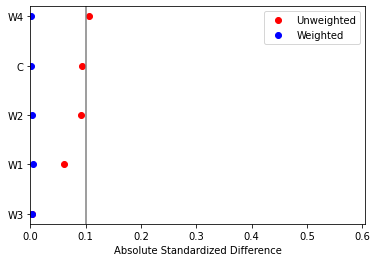

In [17]:
rename_cols = {"smd_w": "Weighted", "smd_u": "Raw", 
               "labels": "Confounder"}

smd = ipw.standardized_mean_differences().rename(columns=rename_cols)
smd = smd.sort_values(by='Confounder')
print(smd[['Confounder', 'Raw', 'Weighted']])

# zEpid plotting functionality
ipw.plot_love()
plt.show()

## Box 18: Assessing IPTW overlap by-hand

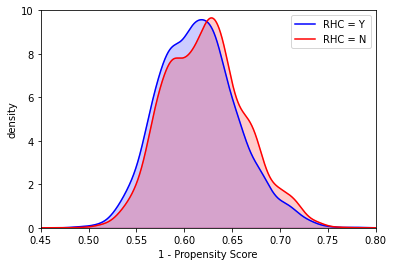

In [18]:
density_t = gaussian_kde(1 - data.loc[data["A"] == 1, 'p_score'])
density_u = gaussian_kde(1 - data.loc[data["A"] == 0, 'p_score'])

x = np.linspace(0, 1, 10000)

ax = plt.gca()
ax.fill_between(x, density_t(x), color="b", alpha=0.2, label=None)
ax.plot(x, density_t(x), color="b", label='RHC = Y')
ax.fill_between(x, density_u(x), color="r", alpha=0.2, label=None)
ax.plot(x, density_u(x), color="r", label='RHC = N')
ax.set_ylim([0, 10])
ax.set_ylabel("density")
ax.set_xlim([0.45, 0.8])
ax.set_xlabel("1 - Propensity Score")
ax.legend()
plt.show()

## Box 19: Assessing overlap with zEpid

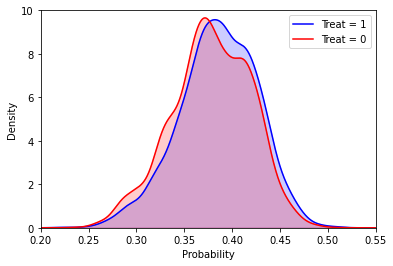

In [19]:
ipw.plot_kde()
plt.ylim([0, 10])
plt.xlim([0.2, 0.55])
plt.show()

# Section 4.2: Marginal structural model with stabilised weights

## Box 20: Computation of the IPTW estimator for the ATE using a MSM

In [20]:
### Unstabilized IPTW ###
fm_pa = smf.glm("A ~ C + W1 + W2 + W3 + W4", 
                data, family=f).fit()
p_score = fm_pa.predict(data)  # Calculating propensity scores
iptw = 1 / np.where(data['A'] == 1, p_score, 1 - p_score)  # IPTW

# Estimating Marginal Structural Model
f = sm.families.family.Binomial(sm.families.links.identity())
fm = smf.gee("Y ~ A", data.index, data,
             cov_struct=sm.cov_struct.Independence(), 
             family=f, weights=iptw).fit()
# NOTE: statsmodels with generate a DomainWarning since the identity-binomial is not bounded
print("Unstabilized Weights")
print("ATE   ", np.round(fm.params['A'], 6))
print("95% CL", np.asarray(fm.conf_int().loc["A"]))

### Stabilized IPTW ###
f = sm.families.family.Binomial()

fm_ma = smf.glm("A ~ 1", data, family=f).fit()  # Numerator
num = np.where(data['A'] == 1, fm_ma.predict(data), 
               1 - fm_ma.predict(data))
fm_pa = smf.glm("A ~ C + W1 + W2 + W3 + W4",  # Denominator
                data, family=f).fit()
den = np.where(data['A'] == 1, fm_pa.predict(data), 
               1 - fm_pa.predict(data))
iptw = num / den  # IPTW

# Estimating Marginal Structural Model
f = sm.families.family.Binomial(sm.families.links.identity())
fm = smf.gee("Y ~ A", data.index, data,
             cov_struct=sm.cov_struct.Independence(), 
             family=f, weights=iptw).fit()
# NOTE: statsmodels with generate a DomainWarning since the identity-binomial is not bounded
print("\nStabilized Weights")
print("ATE   ", np.round(fm.params['A'], 6))
print("95% CL", np.asarray(fm.conf_int().loc["A"]))

/home/pzivich/.pyenv/versions/3.6.5/lib/python3.6/site-packages/statsmodels/genmod/generalized_estimating_equations.py:499: DomainWarning: The identity link function does not respect the domain of the Binomial family.
  DomainWarning)
/home/pzivich/.pyenv/versions/3.6.5/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:296: DomainWarning: The identity link function does not respect the domain of the Binomial family.
  DomainWarning)
/home/pzivich/.pyenv/versions/3.6.5/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:296: DomainWarning: The identity link function does not respect the domain of the Binomial family.
  DomainWarning)


Unstabilized Weights
ATE    0.083024
95% CL [0.05745525 0.1085925 ]


/home/pzivich/.pyenv/versions/3.6.5/lib/python3.6/site-packages/statsmodels/genmod/generalized_estimating_equations.py:499: DomainWarning: The identity link function does not respect the domain of the Binomial family.
  DomainWarning)
/home/pzivich/.pyenv/versions/3.6.5/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:296: DomainWarning: The identity link function does not respect the domain of the Binomial family.
  DomainWarning)
/home/pzivich/.pyenv/versions/3.6.5/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:296: DomainWarning: The identity link function does not respect the domain of the Binomial family.
  DomainWarning)



Stabilized Weights
ATE    0.083024
95% CL [0.05745525 0.1085925 ]


# Section 5.1: Inverse probability weighting plus regression adjustment

## Box 21: Computation of the IPTW-RA estimator for the ATE

In [21]:
f = sm.families.family.Binomial()

fm_a1 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                data.loc[data["A"] == 1],  # Only A=1
                weights=data.loc[data["A"] == 1, 'iptw'], # Box 17
                family=f).fit()
y_a1 = fm_a1.predict(data)

fm_a0 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                data.loc[data["A"] == 0],  # Only A=0
                weights=data.loc[data["A"] == 0, 'iptw'],  # Box 17
                family=f).fit()
y_a0 = fm_a0.predict(data)

ate = np.mean(y_a1 - y_a0)
print("ATE", np.round(ate, 6))
ate = (np.mean(data['iptw']*data['A']*y_a1) / np.mean(data['iptw']*data['A']) - 
       np.mean(data['iptw']*(1-data['A'])*y_a0) / np.mean(data['iptw']*(1-data['A'])))
print("ATE", np.round(ate, 6))

ATE 0.083641
ATE 0.083192


## Box 22: N/A

# Section 5.2: Augmented Inverse Probability Weighting

## Box 23: Computation of the AIPTW estimator for the ATE and bootstrap for statistical inference

In [22]:
# Box 23: Computation of the AIPTW estimator
f = sm.families.family.Binomial()

# Step 1: prediction model for the outcome using regression adjustment
fm_a1 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                data.loc[data["A"] == 1], family=f).fit()
fm_a0 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                data.loc[data["A"] == 0], family=f).fit()
y_a1 = fm_a1.predict(data)
y_a0 = fm_a0.predict(data)

# Step 2: prediction model for the treatment
fm_pa = smf.glm("A ~ C + W1 + W2 + W3 + W4", 
                data, family=f).fit()
p_score = fm_pa.predict(data)

# Step 3: estimating equation
ys_a1 = ((data['A'] * data['Y'])/ (p_score) + 
         (y_a1*(p_score-data['A'])) / p_score)
ys_a0 = (((1-data['A']) * data['Y'])/ (1-p_score) + 
         (y_a0*(data['A']-p_score)) / (1-p_score))
ate = np.mean(ys_a1 - ys_a0)
print("ATE", np.round(ate, 6))

# Step 4: bootstrap confidence intervals
ate_rs = []
for i in range(1000):
    d_star = data.sample(n=data.shape[0], # Same size as input data
                     replace=True)  # Draw with replacement
    fm_a1 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                    d_star.loc[d_star["A"] == 1], family=f).fit()
    fm_a0 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                    d_star.loc[d_star["A"] == 0], family=f).fit()
    y_a1 = fm_a1.predict(d_star)
    y_a0 = fm_a0.predict(d_star)
    fm_pa = smf.glm("A ~ C + W1 + W2 + W3 + W4", 
                    d_star, family=f).fit()
    p_score = fm_pa.predict(d_star)
    ys_a1 = ((d_star['A'] * d_star['Y'])/ (p_score) + 
             (y_a1*(p_score-d_star['A'])) / p_score)
    ys_a0 = (((1-d_star['A']) * d_star['Y'])/ (1-p_score) + 
             (y_a0*(d_star['A']-p_score)) / (1-p_score))
    ate_rs.append(np.mean(ys_a1 - ys_a0))


print("95% Confidence limits for the ATE")
ci_perc = np.percentile(ate_rs, q=[2.5, 97.5])
print("Percentile method:   ", np.round(ci_perc, 6))
ate_se = np.std(ate_rs, ddof=1)
print("Normal approx method:", np.round([ate - 1.96*ate_se,
                                          ate + 1.96*ate_se], 6))

ATE 0.083473
95% Confidence limits for the ATE
Percentile method:    [0.058106 0.109349]
Normal approx method: [0.057769 0.109178]


## Box 24: Computation of the AIPTW estimator for the ATE with zEpid

In [23]:
aipw = zepid.causal.doublyrobust.AIPTW(data, 
                                       exposure="A", 
                                       outcome="Y")
aipw.exposure_model("C + W1 + W2 + W3 + W4", 
                    print_results=False)
aipw.outcome_model("A + C + W1 + W2 + W3 + W4 + "
                   "A:C + A:W1 + A:W2 + A:W3 + A:W4", 
                   print_results=False)
aipw.fit()

print("ATE   ", np.round(aipw.risk_difference, 6))
# zEpid calculates the variance using influence curves
print("95% CL", np.round(aipw.risk_difference_ci, 6))

ATE    0.083473
95% CL [0.058214 0.108733]


# Section 6: Data-Adaptive Estimation: Ensemble Learning Targeted Maximum Likelihood Estimation

## Box 25: Computational implementation of TMLE by-hand

In [24]:
f = sm.families.family.Binomial()
n = data.shape[0]

# Step 1: prediction model for the outcome using regression adjustment
fm_a1 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                data.loc[data["A"] == 1], family=f).fit()
fm_a0 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                data.loc[data["A"] == 0], family=f).fit()
y_a1 = fm_a1.predict(data)
y_a0 = fm_a0.predict(data)
y_a_ = np.where(data['A'] == 1, y_a1, y_a0)

# Step 2: prediction model for the treatment
fm_pa = smf.glm("A ~ C + W1 + W2 + W3 + W4", 
                data, family=f).fit()
p_score = fm_pa.predict(data)

# Step 3: targeting step
logodds_y1 = np.log(probability_to_odds(y_a1))
logodds_y0 = np.log(probability_to_odds(y_a0))
logodds_ya = np.log(probability_to_odds(y_a_))

clever_cov_a1 = data['A']/p_score
clever_cov_a0 = - (1-data['A'])/(1-p_score)

submodel = sm.GLM(data['Y'], 
                  np.column_stack((clever_cov_a1, clever_cov_a0)), 
                  offset=logodds_ya,
                  family=f).fit()
epsilon = submodel.params

# Step 4: calculating ATE
ys_a1 = logistic.cdf(logodds_y1 + epsilon[0] / p_score)
ys_a0 = logistic.cdf(logodds_y0 - epsilon[1] / (1-p_score))
ate = np.mean(ys_a1 - ys_a0)
print("ATE", np.round(ate, 6))

# Step 5: inference via influence curve
ic = (clever_cov_a1 + clever_cov_a0) * (data['Y'] - y_a_) + (y_a1 - y_a0) - ate
sd = np.sqrt(np.nanvar(ic, ddof=1) / n)
cl = [ate - 1.96*sd, ate + 1.96*sd]
print("95% CL", np.round(cl, 6))

ATE 0.083474
95% CL [0.058214 0.108734]


## Box 26: TMLE asnd data-adaptive estimation with zEpid

In [25]:
tmle = zepid.causal.doublyrobust.TMLE(data, 
                                      exposure="A", 
                                      outcome="Y")
tmle.exposure_model("C + W1 + W2 + W3 + W4",
                    print_results=False)
tmle.outcome_model("A + C + W1 + W2 + W3 + W4 + "
                   "A:C + A:W1 + A:W2 + A:W3 + A:W4", 
                   print_results=False)
tmle.fit()

print("ATE   ", np.round(tmle.risk_difference, 6))
print("95% CL", np.round(tmle.risk_difference_ci, 6))

ATE    0.083474
95% CL [0.058214 0.108734]


# Section 7: Simulation

## Box 27: Data generation for the Monte Carlo experiment

In [26]:
def data_generator(n, true_ate=False):
    """Function to generate data consisting of `n` observations"""
    d = pd.DataFrame()
    # Confounders
    d['W1'] = np.round(np.random.uniform(low=1, high=5, size=n))
    d['W2'] = np.random.binomial(n=1, p=0.45, size=n)
    d['W3'] = np.round(np.random.uniform(low=0, high=1, size=n)
                       + 0.8*d['W1'] + 0.75*d['W2'])
    d['W3'] = np.where(d['W3'] > 4, 1, d['W3'])
    d['W4'] = np.round(np.random.uniform(low=0, high=1, size=n)
                       + 0.2*d['W1'] + 0.75*d['W2'])
    # Treatment
    pr_a = logistic.cdf(-1 - 0.15*d['W4'] + 1.5*d['W2'] + 
                        0.75*d['W3'] + 0.25*d['W1'] + 
                        0.8*d['W2']*d['W4'])
    d['A'] = np.random.binomial(n=1, 
                                p=pr_a, 
                                size=n)
    # Potential outcomes
    pr_y1 = logistic.cdf(-3 + 1 + 0.25*d['W4'] + 0.75*d['W3'] + 
                         0.8*d['W2']*d['W4'] + 0.05*d['W1'])
    y1 = np.random.binomial(n=1, p=pr_y1, size=n)
    pr_y0 = logistic.cdf(-3 + 0 + 0.25*d['W4'] + 0.75*d['W3'] + 
                         0.8*d['W2']*d['W4'] + 0.05*d['W1'])
    y0 = np.random.binomial(n=1, p=pr_y0, size=n)
    # Causal consistency
    d['Y'] = np.where(d['A'] == 1, y1, y0)
    # Return generated data
    if true_ate:
        return np.mean(y1 - y0)
    else:
        return d


# Generating true value from super-population
true_ate = data_generator(n=5000000, true_ate=True)

In [27]:
# Setting up SuperLearner libraries
from zepid.superlearner import SuperLearner, StepwiseSL
from sklearn.linear_model import LogisticRegression
from pygam import LogisticGAM, f, s

import warnings
warnings.simplefilter('ignore', RuntimeWarning)  # Hides some NumPy errors for sparse models

family = sm.families.family.Binomial()

sl_library_main = [LogisticRegression(penalty='none', solver='lbfgs'),
                   StepwiseSL(family, selection="backward"), 
                   StepwiseSL(family, selection="forward", order_interaction=1)]
sl_main_labs = ["LogR", "Step.zero", "Step.one"]
sl_main = SuperLearner(sl_library_main, sl_main_labs, folds=5,
                       loss_function='nloglik')

sl_library_alt = [LogisticRegression(penalty='none', solver='lbfgs'),
                  StepwiseSL(family, selection="backward"), 
                  StepwiseSL(family, selection="forward", order_interaction=1),
                  LogisticGAM(f(0) + s(1) + f(2) + s(3) + s(4), lam=0.6)]
sl_alt_labs = ["LogR", "Step.zero", "Step.one", "GAM"]
sl_alt = SuperLearner(sl_library_alt, sl_alt_labs, folds=5,
                      loss_function='nloglik')

### Running simulation

In [28]:
# Simulation
naive_rd, gform_rd, iptw_rd, aipw_rd, tmle_rd = [], [], [], [], []
aipw_slm_rd, aipw_sla_rd, tmle_slm_rd, tmle_sla_rd = [], [], [], []

for i in range(1000):    
    data = data_generator(n=1000)

    # Naive
    fm = smf.ols("Y ~ A + W1 + W2 + W3 + W4", data).fit()
    naive_rd.append(fm.params['A'])
    
    # G-formula
    g_formula = zepid.causal.gformula.TimeFixedGFormula(data, 
                                                    exposure="A", 
                                                    outcome="Y")
    g_formula.outcome_model("A + W1 + W2 + W3 + W4",
                            print_results=False)
    g_formula.fit("all")  # all sets A=1
    y_a1 = g_formula.marginal_outcome
    g_formula.fit("none")  # none sets A=0
    y_a0 = g_formula.marginal_outcome
    gform_rd.append(y_a1 - y_a0)
    
    # IPTW
    ipw = zepid.causal.ipw.IPTW(data, treatment="A", outcome="Y")
    ipw.treatment_model("W1 + W2 + W3 + W4", bound=0.01,
                        stabilized=True, print_results=False)
    ipw.marginal_structural_model("A")
    ipw.fit()
    iptw_rd.append(ipw.risk_difference)

    # AIPW
    aipw = zepid.causal.doublyrobust.AIPTW(data, 
                                       exposure="A", 
                                       outcome="Y")
    aipw.exposure_model("W1 + W2 + W3 + W4", bound=0.01,
                        print_results=False)
    aipw.outcome_model("A + W1 + W2 + W3 + W4", 
                       print_results=False)
    aipw.fit()
    aipw_rd.append(aipw.risk_difference)
    
    # AIPW -- Super Learner main
    aipw = zepid.causal.doublyrobust.AIPTW(data, 
                                       exposure="A", 
                                       outcome="Y")
    aipw.exposure_model("W1 + W2 + W3 + W4", bound=0.01,
                        custom_model=sl_main,
                        print_results=False)
    aipw.outcome_model("A + W1 + W2 + W3 + W4", 
                        custom_model=sl_main,
                       print_results=False)
    aipw.fit()
    aipw_slm_rd.append(aipw.risk_difference)
    
    # AIPW -- Super Learner alternative
    aipw = zepid.causal.doublyrobust.AIPTW(data, 
                                       exposure="A", 
                                       outcome="Y")
    aipw.exposure_model("W1 + W2 + W3 + W4", bound=0.01,
                        custom_model=sl_alt,
                        print_results=False)
    aipw.outcome_model("A + W1 + W2 + W3 + W4", 
                        custom_model=sl_alt,
                       print_results=False)
    aipw.fit()
    aipw_sla_rd.append(aipw.risk_difference)
    
    # TMLE
    tmle = zepid.causal.doublyrobust.TMLE(data, 
                                          exposure="A", 
                                          outcome="Y")
    tmle.exposure_model("W1 + W2 + W3 + W4", bound=0.01,
                        print_results=False)
    tmle.outcome_model("A + W1 + W2 + W3 + W4", 
                       print_results=False)
    tmle.fit()
    tmle_rd.append(tmle.risk_difference)

    # TMLE -- Super Learner main
    tmle = zepid.causal.doublyrobust.TMLE(data, 
                                          exposure="A", 
                                          outcome="Y")
    tmle.exposure_model("W1 + W2 + W3 + W4", bound=0.01,
                        custom_model=sl_main,
                        print_results=False)
    tmle.outcome_model("A + W1 + W2 + W3 + W4", 
                       custom_model=sl_main,
                       print_results=False)
    tmle.fit()
    tmle_slm_rd.append(tmle.risk_difference)
    
    # TMLE -- Super Learner alternative
    tmle = zepid.causal.doublyrobust.TMLE(data, 
                                          exposure="A", 
                                          outcome="Y")
    tmle.exposure_model("W1 + W2 + W3 + W4", bound=0.01,
                        custom_model=sl_alt,
                        print_results=False)
    tmle.outcome_model("A + W1 + W2 + W3 + W4", 
                       custom_model=sl_alt,
                       print_results=False)
    tmle.fit()
    tmle_sla_rd.append(tmle.risk_difference)
    


In [29]:
# Results
result = [naive_rd, gform_rd, iptw_rd, aipw_rd, aipw_slm_rd, 
          aipw_sla_rd, tmle_rd, tmle_slm_rd, tmle_sla_rd]
labels = ["Naive", "G-formula", "IPTW", "AIPW", "AIPW-SL1", 
          "AIPW-SL2", "TMLE", "TMLE-SL1", "TMLE-SL2"]
for x, y in zip(result, labels):
    print("=============================")
    print(y)
    print("-----------------------------")
    print("Abs. Bias:", np.round(np.mean(x - true_ate), 3))
    rel_bias = np.abs(np.mean((x - true_ate) / true_ate)*100)
    print("Rel. Bias:", np.round(rel_bias, 1))
    print("=============================")


Naive
-----------------------------
Abs. Bias: 0.052
Rel. Bias: 28.5
G-formula
-----------------------------
Abs. Bias: 0.005
Rel. Bias: 2.7
IPTW
-----------------------------
Abs. Bias: 0.107
Rel. Bias: 59.0
AIPW
-----------------------------
Abs. Bias: 0.011
Rel. Bias: 5.8
AIPW-SL1
-----------------------------
Abs. Bias: 0.009
Rel. Bias: 5.1
AIPW-SL2
-----------------------------
Abs. Bias: 0.01
Rel. Bias: 5.3
TMLE
-----------------------------
Abs. Bias: 0.017
Rel. Bias: 9.2
TMLE-SL1
-----------------------------
Abs. Bias: 0.014
Rel. Bias: 7.5
TMLE-SL2
-----------------------------
Abs. Bias: 0.015
Rel. Bias: 8.5
